<a href="https://colab.research.google.com/github/poligenius/WildFire-Detection-from-drones-footages/blob/main/START_HACK_Task_I_stage_2_enhancement_test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading the Kaggle API Token
In this cell, you will upload your Kaggle API token to authenticate and access the Kaggle dataset.
The `kaggle.json` file, which contains your API credentials, should be downloaded from your Kaggle account.
To download it, go to your Kaggle account settings, scroll to the API section, and click 'Create New API Token'.
Once you have your `kaggle.json` file, click the 'Browse' button below to upload it to this notebook environment.

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"marcomarini97","key":"7aa03f1ea1ac8cf07844546f8c78fc1b"}'}

# Setting Up Kaggle API Credentials
After uploading your `kaggle.json` file, this cell will run commands to set up the environment
variables so that the Kaggle API can use these credentials. This includes making a `.kaggle`
directory at the root, copying the `kaggle.json` file into this directory, and setting the
appropriate permissions for the file.

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading the Wildfire Dataset
This cell will handle the downloading of the LAST version of the wildfire dataset from Kaggle.
Once executed, the dataset will be downloaded
and saved to the current working directory in Colab.

In [ ]:
!kaggle datasets download -d elmadafri/the-wildfire-dataset

100% 9.94G/9.94G [05:01<00:00, 37.6MB/s]
100% 9.94G/9.94G [05:01<00:00, 35.3MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Unzipping the Dataset
After downloading the dataset, this cell will unzip the dataset. The dataset comes in a
compressed `.zip` file format to save space. Running the command below will extract the
files into a directory that you can then work with in the notebook.

In [ ]:
!unzip the-wildfire-dataset.zip

Archive:  the-wildfire-dataset.zip
  inflating: the_wildfire_dataset_2n_version/test/fire/19196558588_267f24b847_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/20960888741_8c4be2c1df_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/26131736898_9e6a8cd68f_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/26549039025_b4cce14ec7_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/27002088114_aa5cc7f353_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/27335331950_39b376eddd_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/27389369514_cd30397ac2_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/27951228213_2dd961ac1f_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/27968020506_5f1a59f2a5_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/28020330864_d7a2429a7e_o.jpg  
  inflating: the_wildfire_dataset_2n_version/test/fire/28347651877_ce21ed134e_o.png  
  inflating: the_wi

## Setting Up Data Loaders

Before we can start training our model, we need to load our image data into a format that's usable by TensorFlow. This is done by using the `tf.keras.utils.image_dataset_from_directory` function, which conveniently handles images stored in a directory structure.

Here's what we are setting up in this cell:

1. **Directory Paths**: We define the base directory where our dataset is located. Within this base directory, we should have three subdirectories corresponding to our training, validation, and test sets, respectively.

2. **Image Loading Parameters**: We set the batch size and image size. The batch size is the number of images that the model will process at one time during training, and the image size is the dimensions to which all images will be resized.

3. **Data Loaders**: We create data loaders for the training, validation, and test datasets. These loaders will read the images from disk, apply the specified preprocessing, and arrange them into batches.

Note: The `label_mode` is set to 'binary' which indicates that our problem is a binary classification task. If you have more than two classes, change this parameter to 'categorical'.

The `shuffle` parameter is set to `True` for the training dataset to ensure that the model does not learn anything from the order of the images. It's not necessary to shuffle the validation and test sets, but doing so does not harm and ensures that any evaluation of the model is done on a random sample of the data.

After running this cell, `train_dataset`, `val_dataset`, and `test_dataset` will be ready for use in the model training and evaluation steps.

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing

# Define directory paths and constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
learning_rate_initial = 0.02

# Define the directory paths for the training, validation, and test sets
base_dir = '/content/the_wildfire_dataset_2n_version'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Load the datasets using image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'  # Use 'binary' because there are only two classes
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'
)

class_names = train_dataset.class_names
label_map = {class_names.index('fire'): 1, class_names.index('nofire'): 0}

# Define a function to remap the labels
def remap_labels(image, label):
    return image, tf.where(label == 0, 1, 0)  # this will swap 0s and 1s

# Use the `map` function to apply the remap_labels function
train_dataset = train_dataset.map(remap_labels)
val_dataset = val_dataset.map(remap_labels)
test_dataset = test_dataset.map(remap_labels)

Found 1887 files belonging to 2 classes.
Found 402 files belonging to 2 classes.
Found 410 files belonging to 2 classes.


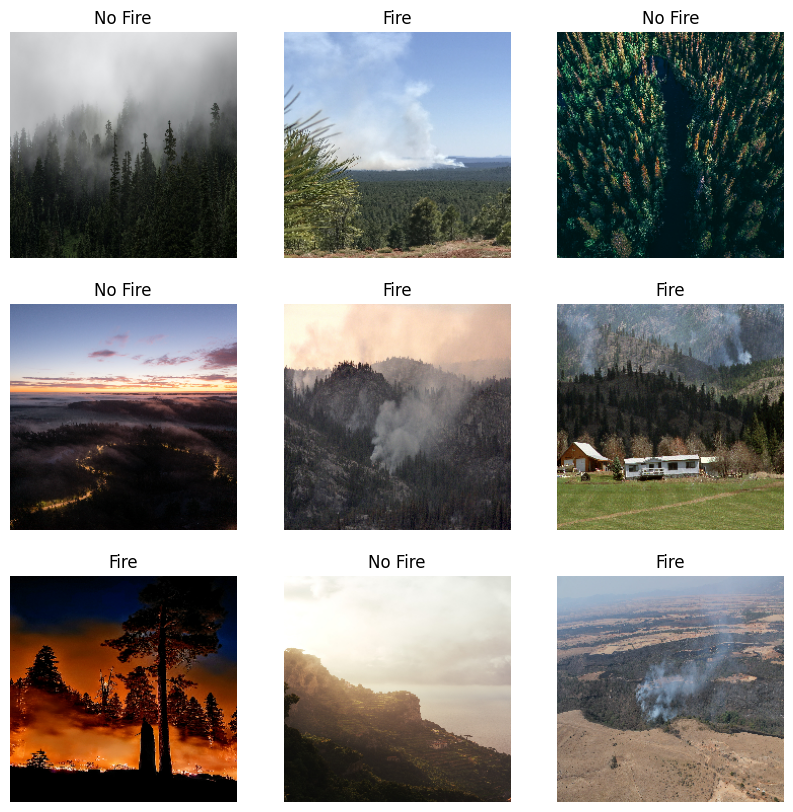

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(min(len(image_batch), 9)):  # Display up to 9 images from the batch
        ax = plt.subplot(3, 3, n+1)
        plt.imshow(image_batch[n] / 255.0)  # Make sure the pixel values are in [0,1] range
        if label_batch[n]:
            plt.title("Fire")
        else:
            plt.title("No Fire")
        plt.axis("off")

image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch, label_batch)


## Optimizing Data Loading

In this cell, we optimize the data loading process for our training, validation, and test datasets. `AUTOTUNE` is a TensorFlow feature that allows the dataset to dynamically adjust the number of images it processes simultaneously, based on the current system conditions.

By calling the `prefetch` method with `buffer_size=AUTOTUNE`, we enable the input pipeline to fetch batches in the background while the model is training. This helps in reducing the time the model has to wait for the data and can improve overall training speed.

Prefetching is a best practice that can significantly improve computational efficiency.

In [ ]:
# Configure the datasets for performance
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Setting Up the Base Model with EfficientNetB0

To leverage the power of transfer learning, we're using a pre-trained model, EfficientNetB0, as the starting point for our own image classification task. Pre-trained on ImageNet, EfficientNetB0 has learned rich feature representations for a wide range of images which can be beneficial for our specific task.
After pre-training and feature extraction, we might want to fine-tune the base model to better suit our specific task. Fine-tuning can lead to significant improvements in accuracy by slightly adjusting the weights of the pre-trained model.


In [ ]:
# Define the model
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True  # Fine-tune the base model

16705208/16705208 [==============================] - 1s 0us/step


## Fine-Tuning the Model

Fine-tuning is a powerful technique to optimize the pre-trained model for our specific task, allowing us to adjust the higher-order feature representations in the pre-trained model to make them more relevant for the classification of our images.

In [ ]:
# Freeze all the layers before the `fine_tune_at` layer
fine_tune_at = 1
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

## Incorporating a Global Average Pooling Layer

After extracting features using the base model, we often have a high-dimensional feature map for each image. To simplify the model and reduce its complexity, we can apply a Global Average Pooling (GAP) layer. The GAP layer reduces each feature map to a single value by calculating the average of all values in the feature map. This process significantly reduces the dimensionality and prepares the data for the final classification layer. To consolidate the features extracted by the base model into a more manageable form, we introduce a Global Average Pooling 2D (GAP) layer. This layer reduces the dimensions of the feature maps from the base model by calculating the average value for each feature map channel. This step is crucial for reducing the model's complexity and computational load without sacrificing the essential information needed for accurate predictions.


In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # Use 'sigmoid' for binary classification

## Building the Complete Model

With all the components ready, we now assemble the complete model. This model incorporates preprocessing, the pre-trained base model for feature extraction, pooling to condense the features, and a prediction layer for output. Additionally, we include a Dropout layer to reduce overfitting by randomly setting input units to 0 at a rate of 0.2 during training.

In [ ]:
# Build the model
model = models.Model(inputs, outputs)

## Compiling the Model

With our model architecture defined, the next step is to compile the model. Compiling the model prepares it for training by specifying the loss function, optimizer, and metrics to use for evaluation.


In [ ]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_initial/10),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training the Model

Now that our model is compiled, we're ready to start the training process. Training the model involves feeding it our training dataset and letting it learn to predict the correct labels. During training, the model will also be validated using a separate dataset to monitor its performance on data it has not seen before.



In [ ]:

# Fit the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=15
)


Epoch 1/15
59/59 [==============================] - 472s 6s/step - loss: 0.4188 - accuracy: 0.8235 - val_loss: 0.3541 - val_accuracy: 0.8308
Epoch 2/15
59/59 [==============================] - 403s 6s/step - loss: 0.2513 - accuracy: 0.9030 - val_loss: 0.2467 - val_accuracy: 0.9179
Epoch 3/15
59/59 [==============================] - 430s 7s/step - loss: 0.1540 - accuracy: 0.9380 - val_loss: 0.3678 - val_accuracy: 0.8831
Epoch 4/15
59/59 [==============================] - 392s 6s/step - loss: 0.1475 - accuracy: 0.9438 - val_loss: 0.3436 - val_accuracy: 0.9030
Epoch 5/15
59/59 [==============================] - 407s 6s/step - loss: 0.1274 - accuracy: 0.9507 - val_loss: 0.3534 - val_accuracy: 0.8806
Epoch 6/15
59/59 [==============================] - 393s 6s/step - loss: 0.0815 - accuracy: 0.9687 - val_loss: 0.3227 - val_accuracy: 0.9055
Epoch 7/15
59/59 [==============================] - 393s 6s/step - loss: 0.0608 - accuracy: 0.9788 - val_loss: 0.2698 - val_accuracy: 0.9055
Epoch 8/15
59

In [ ]:
# Replace 'my_model' with your model's name and choose an appropriate path in your Google Drive
model_name = 'last_hope_first_tuning.h5'
save_path = f'/content/drive/My Drive/{model_name}'

# Save your model
model.save(save_path)
print(f'Model saved to {save_path}')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/last_hope_first_tuning.h5


## AUGMENTING HIDDEN DATASET

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.8 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os

# for blur
import imgaug.augmenters as iaa

# for image rotation
import tensorflow_addons as tfa

def salt_pepper(image, salt_prob, pepper_prob):
    num_pixels = np.prod(image.shape[:2])
    num_salts = np.ceil(num_pixels * salt_prob)
    num_peppers = np.ceil(num_pixels * pepper_prob)

    coords = [np.random.randint(0, i-1 , int(num_salts)) for i in image.shape]
    image[coords[0], coords[1], :] = 1

    coords = [np.random.randint(0, i-1 , int(num_peppers)) for i in image.shape]
    image[coords[0], coords[1], :] = 0

    return image

# The directory containing your images
img_path = '/content/drive/MyDrive/the_wildfire_dataset_2n_version/hidden_dataset/fire'
save_path = '/content/the_wildfire_dataset_2n_version/aug/fire'

files = os.listdir(img_path)

i = 0
for file in files:
    # Load the image
    img = tf.io.read_file(os.path.join(img_path, file))
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image
    #img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # Save the original image
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_original' + '.jpeg'),
        img
    )

    # Create a zoomed version
    zoomed_img = tf.image.central_crop(img, central_fraction=0.7)  # Adjust fraction to your desired zoom
    #zoomed_img = tf.image.resize(zoomed_img, [IMG_SIZE, IMG_SIZE])  # Resize back to original size
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_zoomed' + '.jpeg'),
        zoomed_img
    )

    # Create a version that is flipped
    flipped_img = tf.image.flip_left_right(img)
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_flipped' + '.jpeg'),
        flipped_img
    )

    # Create a version that is rotated
    rotated_img = tfa.image.rotate(img, tf.constant(np.pi/8))  # 45 degree rotation
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_rotated' + '.jpeg'),
        rotated_img
    )

    # Create a version that is Gaussian blurred
    blur = iaa.GaussianBlur(sigma=0.5)  # Adjust sigma to your liking
    img_array = img_to_array(img)
    gaussian_blurred = blur.augment_image(img_array)
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_gaussian' + '.jpeg'),
        gaussian_blurred
    )

    # Create a version that is salt and peppered
    img_array = img_to_array(img)
    salt_pepper_img = salt_pepper(img_array, 0.05, 0.05)  # Adjust salt and pepper probability to your liking
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_salt_pepper' + '.jpeg'),
        salt_pepper_img
    )

    i += 1
    print("aug num: ", i)


aug num:  1
aug num:  2
aug num:  3
aug num:  4
aug num:  5
aug num:  6
aug num:  7
aug num:  8
aug num:  9
aug num:  10


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os

# for blur
import imgaug.augmenters as iaa

# for image rotation
import tensorflow_addons as tfa

def salt_pepper(image, salt_prob, pepper_prob):
    num_pixels = np.prod(image.shape[:2])
    num_salts = np.ceil(num_pixels * salt_prob)
    num_peppers = np.ceil(num_pixels * pepper_prob)

    coords = [np.random.randint(0, i-1 , int(num_salts)) for i in image.shape]
    image[coords[0], coords[1], :] = 1

    coords = [np.random.randint(0, i-1 , int(num_peppers)) for i in image.shape]
    image[coords[0], coords[1], :] = 0

    return image

# The directory containing your images
img_path = '/content/drive/MyDrive/the_wildfire_dataset_2n_version/hidden_dataset/nofire'
save_path = '/content/the_wildfire_dataset_2n_version/aug/nofire'

files = os.listdir(img_path)

i = 0
for file in files:
    # Load the image
    img = tf.io.read_file(os.path.join(img_path, file))
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image
    #img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])

    # Save the original image
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_original' + '.jpeg'),
        img
    )

    # Create a zoomed version
    zoomed_img = tf.image.central_crop(img, central_fraction=0.7)  # Adjust fraction to your desired zoom
    #zoomed_img = tf.image.resize(zoomed_img, [IMG_SIZE, IMG_SIZE])  # Resize back to original size
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_zoomed' + '.jpeg'),
        zoomed_img
    )

    # Create a version that is flipped
    flipped_img = tf.image.flip_left_right(img)
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_flipped' + '.jpeg'),
        flipped_img
    )

    # Create a version that is rotated
    rotated_img = tfa.image.rotate(img, tf.constant(np.pi/8))  # 45 degree rotation
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_rotated' + '.jpeg'),
        rotated_img
    )

    # Create a version that is Gaussian blurred
    blur = iaa.GaussianBlur(sigma=0.5)  # Adjust sigma to your liking
    img_array = img_to_array(img)
    gaussian_blurred = blur.augment_image(img_array)
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_gaussian' + '.jpeg'),
        gaussian_blurred
    )

    # Create a version that is salt and peppered
    img_array = img_to_array(img)
    salt_pepper_img = salt_pepper(img_array, 0.05, 0.05)  # Adjust salt and pepper probability to your liking
    tf.keras.preprocessing.image.save_img(
        os.path.join(save_path, file.split('.')[0] + '_salt_pepper' + '.jpeg'),
        salt_pepper_img
    )

    i += 1
    print("aug num: ", i)


aug num:  1
aug num:  2
aug num:  3
aug num:  4
aug num:  5
aug num:  6
aug num:  7
aug num:  8
aug num:  9
aug num:  10


## Finetuning of model on augmented hidden dataset


In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/last_hope_first_tuning.h5')

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing

# Define directory paths and constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 4
learning_rate_initial = 0.02

# Define the directory paths for the training, validation, and test sets
base_dir = '/content/the_wildfire_dataset_2n_version'
train_dir = os.path.join(base_dir, 'aug')

# Load the datasets using image_dataset_from_directory
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='binary'  # Use 'binary' because there are only two classes
)

class_names = train_dataset.class_names
label_map = {class_names.index('fire'): 1, class_names.index('nofire'): 0}

# Define a function to remap the labels
def remap_labels(image, label):
    return image, tf.where(label == 0, 1, 0)  # this will swap 0s and 1s

# Use the `map` function to apply the remap_labels function
second_train_dataset = train_dataset.map(remap_labels)

Found 120 files belonging to 2 classes.


In [ ]:
# unfreezing more layers

second_fine_tune = -10
for layer in model.layers[second_fine_tune:]:
    layer.trainable = True
for layer in model.layers[:second_fine_tune]:
    layer.trainable = False

In [ ]:
# Assume `model` is your model
new_learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(lr=new_learning_rate)

# Now you can continue training on the new dataset
model.fit(second_train_dataset, validation_data=val_dataset,
    epochs=7)

Epoch 1/7
30/30 [==============================] - 115s 3s/step - loss: 0.6309 - accuracy: 0.8083 - val_loss: 2.8246 - val_accuracy: 0.5970
Epoch 2/7
30/30 [==============================] - 84s 3s/step - loss: 0.3221 - accuracy: 0.9000 - val_loss: 1.3743 - val_accuracy: 0.5697
Epoch 3/7
30/30 [==============================] - 85s 3s/step - loss: 0.3469 - accuracy: 0.8833 - val_loss: 1.8541 - val_accuracy: 0.5821
Epoch 4/7
30/30 [==============================] - 69s 2s/step - loss: 0.2887 - accuracy: 0.9000 - val_loss: 1.0862 - val_accuracy: 0.5771
Epoch 5/7
30/30 [==============================] - 70s 2s/step - loss: 0.1018 - accuracy: 0.9750 - val_loss: 1.2711 - val_accuracy: 0.5920
Epoch 6/7
30/30 [==============================] - 84s 3s/step - loss: 0.0493 - accuracy: 0.9833 - val_loss: 2.0182 - val_accuracy: 0.5896
Epoch 7/7
30/30 [==============================] - 69s 2s/step - loss: 0.0148 - accuracy: 0.9917 - val_loss: 1.9946 - val_accuracy: 0.5373


## Saving Your Trained Model to Google Drive

After training your model, it's important to save it so that you can share it with the hackathon organizers and use it for further evaluation. In the following cell, we mount your Google Drive for easy file access and save your trained model directly to it. This ensures that your model is stored securely and can be accessed from anywhere, anytime.

In [ ]:
# Replace 'my_model' with your model's name and choose an appropriate path in your Google Drive
model_name = 'last_hope.h5'
save_path = f'/content/drive/My Drive/{model_name}'

# Save your model
model.save(save_path)
print(f'Model saved to {save_path}')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved to /content/drive/My Drive/last_hope.h5


## Important: Protect Your API Key

Before submitting this notebook, please ensure that you remove your `kaggle.json` file from the notebook environment. To do this, you can simply delete the cell that uploaded the `kaggle.json` file and any cells that may have outputted its contents.

Furthermore, before pushing this notebook to GitHub or any other public repository, ensure that your API key is not visible or stored in the code. Do not share or expose your credentials in any way within this notebook.

**To remove the kaggle.json file from your Colab environment, you can use the following command:**

```python
!rm -rf ~/.kaggle/kaggle.json


## Evaluating the Trained Model on the test dataset

With your model now trained and saved, the next critical step is to assess its performance on a new set of data. This evaluation will provide you with valuable insights into how well your model generalizes to unseen examples, reflecting its potential effectiveness in real-world scenarios. In the following code cell, we will use the .evaluate() method, which will output the model's accuracy and loss on the dataset. It's important to note that this step is crucial for understanding your model's strengths and areas for improvement.

In [ ]:

# Evaluate the model
model.evaluate(test_dataset)

13/13 [==============================] - 81s 2s/step - loss: 2.0200 - accuracy: 0.5561


[2.0200390815734863, 0.5560975670814514]